
# <center>Python - NumPy <a class="tocSkip"></center>
# <center>QTM 350: Data Science Computing <a class="tocSkip"></center>    
# <center>Davi Moreira <a class="tocSkip"></center>

## Learning Objectives 


- Understand at a high level how NumPy arrays are stored in memory.
- Explain the concept of "strides" in NumPy.
- Use strides to efficiently access data with NumPy.

## Introduction
<hr>

The material assumes no prior knowledge of Python. Experience with programming concepts or another programming language will help, but is not required to understand the material.

<br>

<center>
<div>
<img src="https://raw.githubusercontent.com/davi-moreira/2024S_dsc_emory_qtm_350/main/lecture_material/material-topic-03/img/py4ds.png" width="200"/>
</div>
</center>


This topic material is based on the [Python Programming for Data Science](https://www.tomasbeuzen.com/python-programming-for-data-science/README.html) book and adapted for our purposes in the course.


## Summary
<hr>

We will see more about how NumPy manages and stores arrays in memory. We'll stress that a thorough understanding of the NumPy internals like how memory is handled and accessed is really more for developers working on super-optimized algorithms or for those interested in these kinds of things. 

This chapter draws on excellent material presented in:
- [The NumPy documentation](https://numpy.org/doc/stable/dev/internals.html#numpy-internals).
- [Guide to NumPy](https://web.mit.edu/dvp/Public/numpybook.pdf) by Travis Oliphant, 2006.

In [ ]:
import numpy as np

## Numpy Arrays


Recall that an N-dimensional array ("ndarray") is just a *homogenous* set of elements. You may be more familiar with the term "vector" (a 1-d array) or a "matrix" (a 2-d array). There are two key pieces of information that describe any given ndarray:

1. The shape of the array; and,
2. The datatype of the array elements.

### Array Shape

You can think of the shape of an ndarray as the "length" of each dimension. For example, consider the following vector which has 6 elements and shape `(6,)`:

In [ ]:
a = np.array([1, 2, 3, 4, 5, 6])
a

This vector has one dimension full of 6 elements:

In [ ]:
print(f"The shape of this ndarray is: {a.shape}")
print(f" The number of dimensions is: {a.ndim}")
print(f"   The number of elements is: {a.size}")

Compare this vector to the following matrix of shape `(2, 3)`:

In [ ]:
a = np.array([[1, 2, 3],
              [4, 5, 6]])
a

In [ ]:
print(f"The shape of this ndarray is: {a.shape}")
print(f" The number of dimensions is: {a.ndim}")
print(f"   The number of elements is: {a.size}")

Finally, here's a 4-d array:

In [ ]:
a = np.arange(36).reshape(2, 3, 3, 2)
a

In [ ]:
print(f"The shape of this ndarray is: {a.shape}")
print(f" The number of dimensions is: {a.ndim}")
print(f"   The number of elements is: {a.size}")

### Array Data Type

All ndarrays are homogeneous, meaning that every element has the exact same data-type (e.g., integer, float, string, etc) which takes up the exact same amount of memory.

For example, consider the following 1d-array which is full of 8-bit integers (`int8`):

In [ ]:
a = np.array([1, 2, 3, 4, 5, 6], dtype='int8')
a

One byte is equal to eight bits ([refresh yourself on bits and bytes here](https://web.stanford.edu/class/cs101/bits-bytes.html)), so for this array of `int8` data-types, we would expect each element to take up one byte. We can confirm using:

In [ ]:
a.itemsize

> An aside on the difference between e.g., `int8`, `int16`, `int32`. The number here refers to the number of bits used to represent each integer. For example, `int8` is an integer represented with one byte (one byte = 8 bits). Recall that bits are the basic unit of information "0/1" used by computers. So the maximum *unsigned* number that can be held with an `int8` datatype is: 2^8 (but because Python indexes from 0, the unsigned range of `int8` is 0 to 257). If we wish to have negative numbers, we need to use one of those bits to represent the sign, and we are left with 2^7 bits to make numbers with, and so the signed range of `int8` is -128 to +127. Likewise, `int16` has an unsigned range of 0 to 65,535 (2^16), or a signed range of -32,768 to +32,767, etc. It's interesting to watch what happens if you try to use a dtype that does not support the number you wish to store:

In [ ]:
np.array([126, 127, 128, 129, 130, 131, 132], dtype='int8')

>Above, notice how when we exceeded the integer 127 (the max of the `int8` signed range), NumPy automatically represents this number by counting up from the minimum of the signed range (-128). Cool! Of course, this wouldn't be a problem if we used `int16`:

In [ ]:
np.array([126, 127, 128, 129, 130, 131, 132], dtype='int16')

Technically it is possible to have mixed data-types in an array (i.e., a heterogenous array), but in this case, the array still "sees" each element as the same thing: a reference to some Python object, and the dtype would be "object".

In [ ]:
a = np.array([['a', 'b', 'c'], 1, 3.14159], dtype='object')
a

Above is an ndarrays of objects, each one being a reference to some other Python object with its own data-type:

In [ ]:
list(map(type, a))

Using arrays like this negates much of the optimized functionality that comes with them. For mixed data-types, one would typically use other structures like lists or dictionaries.

## Memory Layout and Strides
<hr>

Now that we've covered the basic concepts of ndarrays, we can talk more about how arrays are represented in memory. An ndarray is stored as a single “chunk” of memory starting at some location. It's helpful to think of it as a one-dimensional sequence in memory but with "fancy indexing" that can help map an N-dimensional index (for ndarrays) into that one-dimensional representation.

Consider "**Panel a**" in the below conceptual figure from the paper [Array programming with NumPy](https://www.nature.com/articles/s41586-020-2649-2), showing how a 2d-array of data-type `int64` (8 bytes) is represented in memory as a single chunk:

![](https://raw.githubusercontent.com/davi-moreira/2024S_dsc_emory_qtm_350/main/lecture_material/material-topic-03/img/numpy_paper.png)


That word **strides** is the number of bytes you need to step in each dimension when traversing the array. As you can see in the example, the **stride** information is particularly important for mapping the chunk of memory back to a n-dimensional array structure. So in the above case, the strides is `(24, 8)` meaning 24 bytes (three 8-byte `int64` elements) and 8 bytes (one 8-byte `int64` element), meaning that every 3 elements we increment our first dimension (i.e., move to the next row) and every 1 element we increment our second dimension (i.e., move to the next column).

Let's go through another example:

In [ ]:
a = np.array([[1, 2], [3, 4], [5, 6]], dtype='int16')
a

Here we have an ndarray of shape `(3, 2)` and with a dtype of `int16` (2 bytes per element in the array). We would expect the stride to be `(4, 2)` (every 4 bytes, which is 2 elements here for `int16`, we begin a new row, and every 2 bytes, which is 1 element here, we begin a new column). We can confirm with:

In [ ]:
a.strides

Neat! We could actually change how our ndarray maps from the memory block back to the ndarray by changing the stride information:

In [ ]:
a.strides = (2, 4)
a

To further drive the point home, what do you expect the strides to be of a 1D array? In that case, there is only one dimension to traverse, so we'd expect the strides to just be the number of bytes of 1 element, `(2,)` (i.e., every 2 bytes, which is one `int16` element). Let's confirm:

In [ ]:
a = a.flatten()
a

In [ ]:
a.strides

Finally, let's look at the strides of the following 3D array of size `(3,3,2)` but with the data-type `int8` (so that 1 byte = 1 element which makes interpreting strides a little easier). Visualizing 3D arrays starts to get a bit tricker, but you can think of them as matrices stacked together like slices in a loaf of bread, or multiple chessboards stacked on top of each other.

In [ ]:
a = np.arange(18, dtype='int8').reshape(3, 3, 2)
a

In [ ]:
a.strides

Now things are getting a little more confusing! The above is saying that every 6 elements we increment a "depth dimension", every 2 elements we increment a "row dimension" and every 1 element we increment a "column dimension". Using our chessboard analogy, every 6 elements in memory we move to the next chessboard in the stack, every 2 elements we move down one row of a chessboard and every element we move across 1 column of our chessboard. 

## Why Do We Care?
<hr>

### Reshaping

One sometimes confusing topic in NumPy is understanding how ndarrays are reshaped. But now that you understand how ndarrays are represented in memory, you can better understand how reshaping works in NumPy too! Basically, you can think of reshaping as viewing that "chunk" of memory in a different way (reading it into a different shape but preserving the ordering of the data in memory). Consider the same 2D array we just saw earlier, but with the data-type `int8` (so that 1 byte = 1 element which makes interpreting strides a little easier):

In [ ]:
a = np.array([[1, 2], [3, 4], [5, 6]], dtype='int8')
a

In [ ]:
a.strides

When we reshape the array, think of it as flattening the array out:

In [ ]:
a.flatten()

And then reading that data back into a different shape with different strides. Below I'll change the shape to be `(2, 3)`, which means that we'll need strides of `(3, 1)` (every 3 elements, increment a row, every 1 element, increment a column in the array).

In [ ]:
a.shape = (2, 3)
a.strides = (3, 1)
a

> Above, we didn't need to do `a.strides`. When we changed the shape to `(2, 3)`, NumPy already took care of changing the strides for us, but we are showing it for demonstration purposes.

The same logic applies to reshaping ndarrays of more than 2 dimensions. For example:

In [ ]:
a = np.arange(18, dtype='int8')
a

In [ ]:
a = a.reshape(3, 3, 2)
a

In [ ]:
a.strides

In the previous example, we have three 2D matrix stacked together (let's call them "slices"). We use the first 6 elements of our flattened array to fill in the first "slice", and within that 2D slice, those elements are arranged in rows and columns dictated by the strides (i.e., every 2 elements increment a row and every 1 element increment a column). Once we've used the first 6 elements, we traverse a dimensional "slice" and use the next 6 element to fill that 2D slice. We then repeat that one more time for the last "slice".

You might be wondering two things at this point:

1. Why is our array above composed of 3 slices of 3x2 matrices and not 2 slices of 3x3 matrices? 
2. How did NumPy decide to fill each 2D matrix slice with elements first, why not fill along the "depth" dimension first?

These questions are related and actually much deeper than you might expect. They are explained in detail in the [NumPy documentation](https://numpy.org/doc/stable/dev/internals.html#numpy-internals) and in section *2.3 Memory Layout of ndarray* in the book [Guide to NumPy](https://web.mit.edu/dvp/Public/numpybook.pdf) by Travis Oliphant, but they are to do with the fundamental implementation of how NumPy reads data from memory.

Briefly, NumPy uses "row-major" indexing when reading data from memory which basically means that "grouping" starts from the left most index. So for a 2D array, the order is `(row, column)`, for a 3D array the order is `(depth, row, column)`, for a 4D array it is `(4th dimension, depth, row, column)`, etc. One way to think about this is that the ndarray is a container, in the 3D case you can think of a cube made up of stacked matrices. You can enter this for container ("dimension") and view a matrix. The next container is a "row" of values which comprises one smaller container for each "column". There are two overarching styles that dictate the way data is read in from memory, they are the "C style" and "Fortran style". NumPy uses the "C style" by default which is what we saw previously:

In [ ]:
a = np.arange(18, dtype='int8').reshape(3, 3, 2, order="C")
a

But there is also the "Fortran style", which you can see in the example below and can specify using the `order` argument, which appears to fill the "depth" dimension first:

In [ ]:
a = np.arange(18, dtype='int8').reshape(3, 3, 2, order="F")
a

These implementation details are really necessary to know if you are developing algorithms or packages like NumPy that are directly interfacing with a computer's memory.

### Super-speed Code

Knowing about how ndarrays are stored in memory and what strides are can help us leverage some pretty nifty tricks to speed up our numpy code. Consider performing convolution on a 2D image by passing a filter window of "weights" over the image pixels. For example:

![](https://raw.githubusercontent.com/davi-moreira/2024S_dsc_emory_qtm_350/main/lecture_material/material-topic-03/img/conv.gif)


Source: [hackernoon.com](https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59)



There are plenty of ways to solve this problem. The goal is really to apply our filter to windowed segments of our array. One way we can "view" our array as windows is using strides and the `numpy.lib.stride_tricks` module. Here's a image of yours truly:

In [37]:
import time
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'figure.figsize': (8,6), 'axes.grid': False})

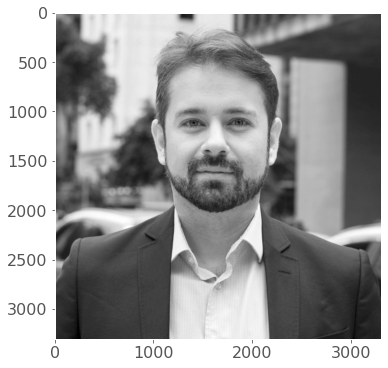

In [38]:
image = plt.imread('img/davi_moreira.JPG')[:,:,0]
plt.imshow(image, cmap='gray');

This is the filter I want to apply to the image:

In [41]:
f = np.array([[-2, -1, 0],
              [-1, 1, 1],
              [0, 1, 2]])

Now let's use strides to view the image as 3 x 3 windows, so we can there just apply the filter to every single window. Basically the goal here is to view our array as a series of 3x3 windows. So think of this as for each pixel in our image, we want to view a 3x3 window around that pixel. We have 400x400 pixels, and if we have a 3x3 window for each pixel, we will have a 4D view of our array with shape `(400, 400, 3, 3)`. In this case, we can't have a 3x3 window at the edges of the image, so let's cut those off with our final shape being `(398, 398, 3, 3)` (but you could just pad the image with 0's to apply the filter at the edges if you wanted to). Once we have our 4D view, we can just apply the filter to each of those 3x3 windows and sum the numbers in each window. No `for` loops or complex functions needed!

Wall time taken for convolution: 1.2446s


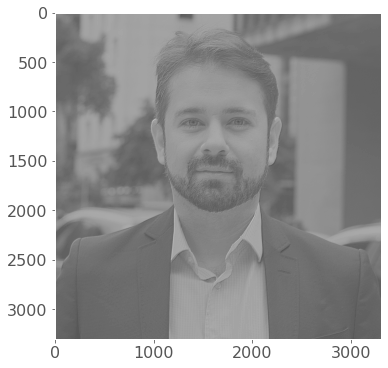

In [42]:
start = time.time()    # start time
size = f.shape[0]      # filter size
win_img = as_strided(  # Now use as_strided to get a windowed view of the array
    image,             # image to view as windows
    shape=(image.shape[0] - size + 1, image.shape[1] - size + 1, size, size),  # the shape of the new view (398, 398, 3, 3), the edge pixels are cut-off, but we could always pad if we wanted to here
    strides=image.strides * 2,  # this just duplicates the strides as we are now working in 4 dimensions, strides will be (6400, 16, 6400, 16)
)
filtered_image = (win_img * f).sum(axis=(2, 3))  # apply filter to each window (the 3rd and 4th dimensions of win_img)
plt.imshow(filtered_image, cmap="gray")
print(f"Wall time taken for convolution: {time.time()-start:.4f}s")

That is some wicked fast convolution! 🚀


In [43]:
!jupyter nbconvert _06-py-numpy-addendum.ipynb --to html --template classic --output 06-py-numpy-addendum.html

[NbConvertApp] Converting notebook _06-py-numpy-addendum.ipynb to html
[NbConvertApp] Writing 554783 bytes to 06-py-numpy-addendum.html


# <center>Thank you!<a class="tocSkip"></center>